In [1]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C:\Users\ricca\AppData\Local\Temp\ipykernel_18200\4233083143.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [3]:
data = pd.read_csv(parent+r'\RES2.txt', sep='\t')

In [4]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [5]:
F = data['F']
I = data['I']
Q = data['Q']

In [6]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

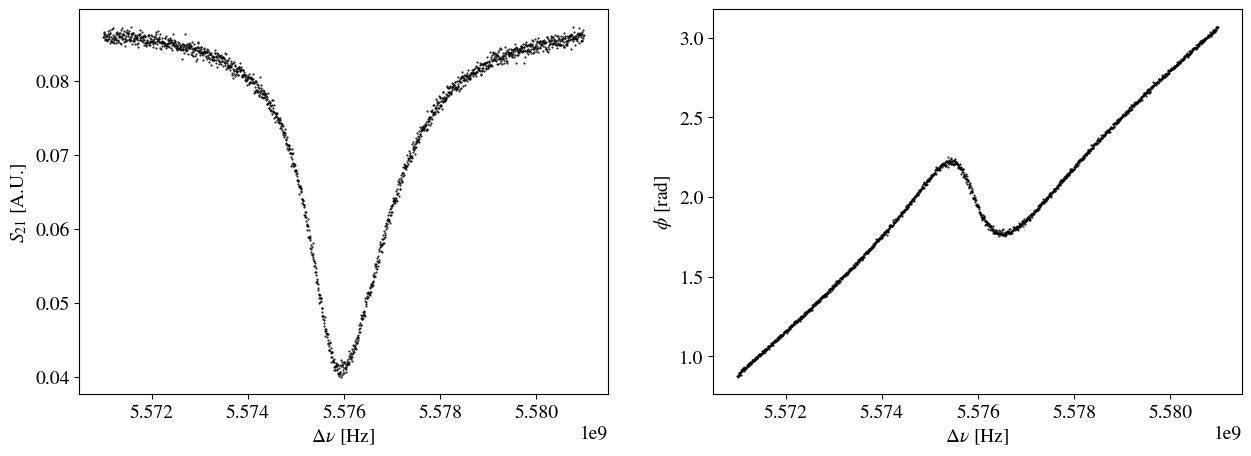

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [8]:
A = 20*np.log10(np.sqrt(A))
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [9]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [10]:
p0 = [1e-21,1e-15,-10,2e3,6e3,3.2,5.576*1e9]

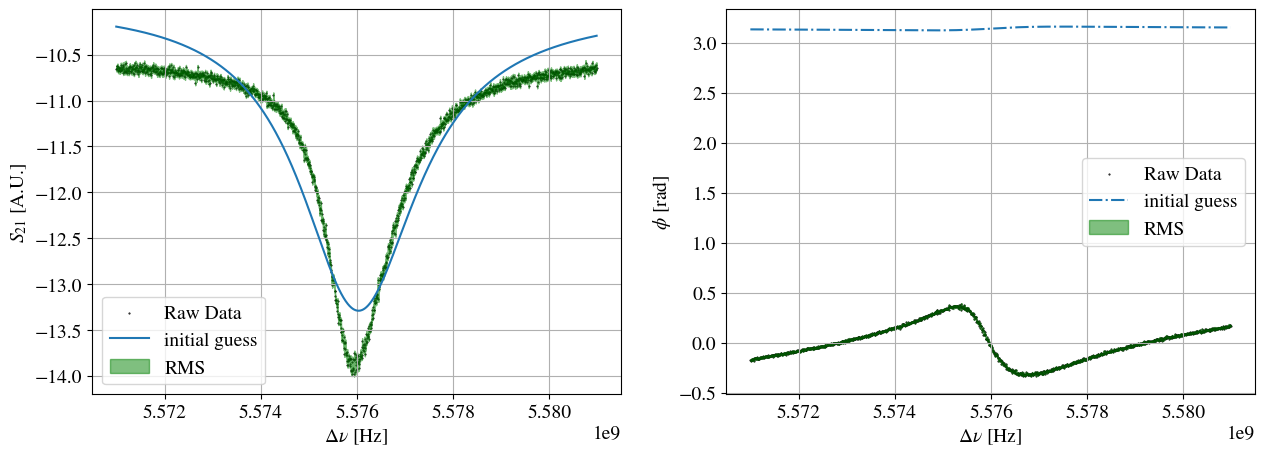

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [12]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4197 (χ²/ndof = 2.6)       │              Nfcn = 358              │
│ EDM = 1.01e-06 (Goal: 0.0002)    │            time = 1.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 2.01e-18  │ 0.04e-18  │            │            │         │         │       │
│ 1 │ x1   │-36.82e-12 │ 0.11e-12  │            │            │         │         │       │
│ 2 │ x2   │   -72.9   │    1.2    │            │            │         │         │       │
│ 3 │ x3   │  3.735e3  │  0.006e3  │            │            │         │         │       │
│ 4 │ x4   │ 11.891e3  │  0.018e3  │            │            │         │         │       │
│ 5 │ x5   │  3.3278   │  0.0020   │            │            │         │         │       │
│ 6 │ x6   │5.5759203e9│0.0000013e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                             x0                             x1                             x2                             x3                             x4                             x5                             x6 │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                       1.43e-39                  -320.2834e-36    -44.3305398608231655544e-21    -11.8010759966060323478e-21    -65.4120086462733922872e-21        61.5492938794809774e-24 -31.0520191070482063366853e-18 │
│ x1 │                  -320.2834e-36                       1.24e-26             9.969147530221e-15          -258.473647331315e-15          -991.948640245874e-15              -27.235919502e-18         17.687742378074606e-12 │
│ x2 │    -44.3305398608231655544e-21             9.969147530221e-15                           1.38                            0.4                            2.0                      -1.914e-3                          965.6 │
│ x3 │    -11.8010759966060323478e-21          -258.473647331315e-15                            0.4                           33.9                             86                         107e-6                           -389 │
│ x4 │    -65.4120086462733922872e-21          -991.948640245874e-15                            2.0                             86                            308                        -679e-6                        -0.64e3 │
│ x5 │        61.5492938794809774e-24              -27.235919502e-18                      -1.914e-3                         107e-6                        -679e-6                       3.89e-06                      -2.188942 │
│ x6 │ -31.0520191070482063366853e-18         17.6877

In [13]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.227e+05 (χ²/ndof = 327.9)│             Nfcn = 10004             │
│ EDM = 0.00203 (Goal: 0.0002)     │            time = 5.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 2.26e-18  │ 0.24e-18  │            │            │         │         │       │
│ 1 │ x1   │   33e-9   │   4e-9    │            │            │         │         │       │
│ 2 │ x2   │    300    │    40     │            │            │         │         │       │
│ 3 │ x3   │  9.425e3  │  0.018e3  │            │            │         │         │       │
│ 4 │ x4   │   20.5    │    2.7    │            │            │         │         │       │
│ 5 │ x5   │  3.2314   │  0.0017   │            │            │         │         │       │
│ 6 │ x6   │5.5759216e9│0.0000009e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                         x0                         x1                         x2                         x3                         x4                         x5                         x6 │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                   5.67e-38          1.00076164676e-27 9.41727121194531946458e-18 -774.66851606692171117e-21 -630.49116901845343364e-21      21.61098307531690e-24   24.55987762420472365e-21 │
│ x1 │          1.00076164676e-27                   1.77e-17           166.112869374e-9           -13.674733917e-9           -11.121345129e-9                381.117e-15             502.790691e-12 │
│ x2 │ 9.41727121194531946458e-18           166.112869374e-9                   1.56e+03                    -0.13e3                       -105                  3.5862e-3                          0 │
│ x3 │ -774.66851606692171117e-21           -13.674733917e-9                    -0.13e3                        341                          9                  1.5970e-3                    -1.27e3 │
│ x4 │ -630.49116901845343364e-21           -11.121345129e-9                       -105                          9                       7.01                  -234.5e-6                         -2 │
│ x5 │      21.61098307531690e-24                381.117e-15                  3.5862e-3                  1.5970e-3                  -234.5e-6                   2.76e-06                 -1.1645860 │
│ x6 │   24.55987762420472365e-21             502.790691e-12                          0                    -1.27e3                         -2                 -1.1645860                   8.89e+05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────

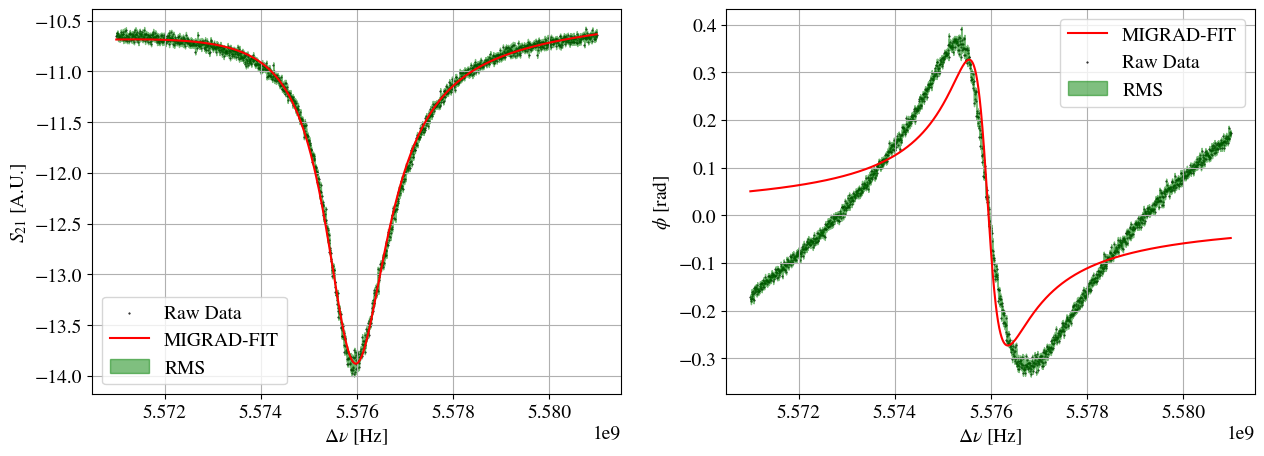

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

Text(5571000000.0, -12, '$\\chi^{2}_{0} = $2.63')

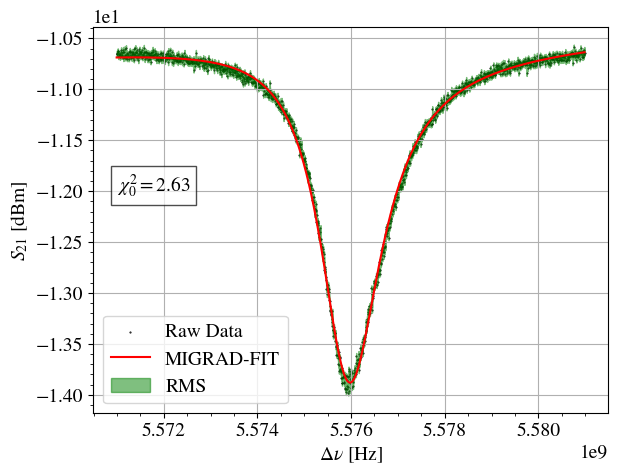

In [18]:
fig, axs = plt.subplots(1,1)
axs.scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs.plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs.set_xlabel(r'$\Delta \nu$ [Hz]')
axs.set_ylabel(r'$S_{21}$ [dBm]')
axs.fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs.legend()
axs.minorticks_on()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# Place the combined text with a bounding box
axs.text(5.571*1e9,-12,r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}",
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

In [50]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  3734.721893839281
Q(phase) =  9424.922849125292
Q_c(S21) =  11890.816821538274
Q_c(phase) =  21.713688169078452


In [51]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  2842.0712224998233
